In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
df = pd.read_csv('dailysales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Handle any missing values
df = df.fillna(df.mean())

# Scale the data
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df['sales'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Use 7 days as sequence length since it's daily sales data
sequence_length = 7
X, y = create_sequences(sales_scaled, sequence_length)

# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Build model
model = Sequential([
    # Input layer
    InputLayer((sequence_length, 1)),
    
    # First LSTM layer
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second LSTM layer
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third LSTM layer
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    
    # Dense layers
    Dense(16, activation='relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(1, activation='linear')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse'
)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

C:\Users\umidu\AppData\Local\Temp\ipykernel_16456\3935710788.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 1.3381 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4744 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3870 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2239 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1888 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1374 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1306 - val_loss: 0.0035 - learning_rate: 2.0000e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1142 - val_loss: 0.0040 - learning_rate: 2.0000e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0906 - val_loss: 0.0044 - learning_rate: 2.0000e

In [6]:
 X_train

array([[[0.11127368],
        [0.08302011],
        [0.10244444],
        ...,
        [0.09084029],
        [0.08806539],
        [0.11505764]],

       [[0.08302011],
        [0.10244444],
        [0.11455311],
        ...,
        [0.08806539],
        [0.11505764],
        [0.02676522]],

       [[0.10244444],
        [0.11455311],
        [0.09084029],
        ...,
        [0.11505764],
        [0.02676522],
        [0.07444313]],

       ...,

       [[0.08618602],
        [0.01104917],
        [0.04154789],
        ...,
        [0.51262582],
        [0.24320779],
        [0.01869277]],

       [[0.01104917],
        [0.04154789],
        [0.07914785],
        ...,
        [0.24320779],
        [0.01869277],
        [0.11707575]],

       [[0.04154789],
        [0.07914785],
        [0.51262582],
        ...,
        [0.01869277],
        [0.11707575],
        [0.0191973 ]]])

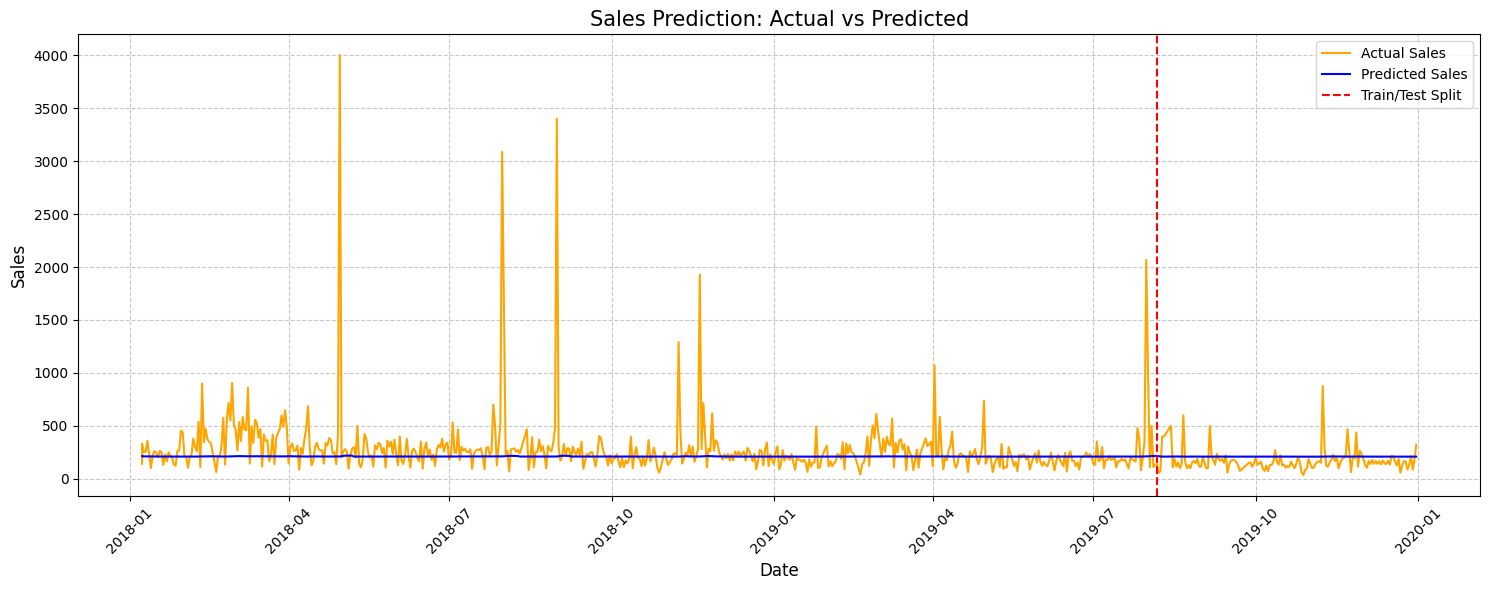


Test Set Metrics:
Root Mean Square Error: 111.65
Mean Absolute Error: 80.60
R-squared Score: -0.131


In [2]:
import matplotlib.pyplot as plt

# Get real values
y_train_real = scaler.inverse_transform(y_train)
y_test_real = scaler.inverse_transform(y_test)

# Combine train and test predictions
all_predictions = np.concatenate([train_predictions, test_predictions])
all_real_values = np.concatenate([y_train_real, y_test_real])

# Create time index for plotting
time_index = df.index[sequence_length:].values

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(time_index, all_real_values, label='Actual Sales', color='orange')
plt.plot(time_index, all_predictions, label='Predicted Sales', color='blue')

# Add vertical line to separate train and test sets
split_date = time_index[train_size]
plt.axvline(x=split_date, color='r', linestyle='--', label='Train/Test Split')

# Customize the plot
plt.title('Sales Prediction: Actual vs Predicted', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics for test set
mse = mean_squared_error(y_test_real, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, test_predictions)
r2 = r2_score(y_test_real, test_predictions)

print("\nTest Set Metrics:")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.3f}")

In [9]:
y_train_real[:10], train_predictions[:10] 

(array([[142.],
        [331.],
        [249.],
        [258.],
        [358.],
        [230.],
        [103.],
        [222.],
        [262.],
        [245.]]),
 array([[212.28345],
        [212.06487],
        [211.83586],
        [211.4808 ],
        [211.10951],
        [210.92117],
        [210.76958],
        [210.50252],
        [210.42702],
        [210.25044]], dtype=float32))

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('dailysales.csv')

# Display the first few rows to understand the structure of the data
print(df.head())
df=df.groupby('date').sum()
df=df.resample(rule='MS').sum()

# Assuming 'Date' and 'Sales' columns exist in the dataset
# Convert 'Date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Plot the 'Sales' over 'Date'
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], label='Daily Sales')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales over Time')

# Add legend
plt.legend()

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


        date  sales
0  01-Jan-18  477.0
1  02-Jan-18  365.0
2  03-Jan-18  442.0
3  04-Jan-18  490.0
4  05-Jan-18  396.0


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'